In [88]:
import numpy as np
import pandas as pd
import yfinance as yf

In [89]:
stock_symbol = 'TITAN.NS'
stock_data = yf.download(stock_symbol,  period="max")

[*********************100%%**********************]  1 of 1 completed


In [90]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-01-01,5.800000,5.800000,5.750000,5.750000,5.188006,4000
1996-01-02,5.800000,5.850000,5.700000,5.752500,5.190261,24000
1996-01-03,5.752500,5.750000,5.650000,5.700000,5.142892,22000
1996-01-04,5.650000,5.650000,5.550000,5.607500,5.059435,46000
1996-01-05,5.500000,5.550000,5.450000,5.455000,4.921839,20000
...,...,...,...,...,...,...
2024-04-25,3595.000000,3602.500000,3541.000000,3571.100098,3571.100098,1889163
2024-04-26,3588.000000,3593.250000,3556.300049,3584.800049,3584.800049,798783
2024-04-29,3585.000000,3613.449951,3573.149902,3604.850098,3604.850098,703524


In [91]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


stock_data.reset_index(inplace=True)

# Extract the 'Date' and 'Close' columns
data = stock_data[['Date', 'Close']].copy()

In [92]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

# Function to create dataset
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back)])
        y.append(data[i + look_back, 0])  # Close price is the label (index 0)
    return np.array(X), np.array(y)

# Create dataset with look-back window
look_back = 60  # Adjust this window size as needed
X, y = create_dataset(scaled_data, look_back)

# Reshape input data for LSTM (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [93]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [94]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(X, y, epochs=50, batch_size=32)

Epoch 1/50
221/221 [==============================] - 10s 20ms/step - loss: 0.0030
Epoch 2/50
221/221 [==============================] - 5s 24ms/step - loss: 7.7043e-04
Epoch 3/50
221/221 [==============================] - 5s 21ms/step - loss: 6.8656e-04
Epoch 4/50
221/221 [==============================] - 3s 12ms/step - loss: 7.7547e-04
Epoch 5/50
221/221 [==============================] - 3s 11ms/step - loss: 6.2386e-04
Epoch 6/50
221/221 [==============================] - 3s 12ms/step - loss: 6.1906e-04
Epoch 7/50
221/221 [==============================] - 3s 15ms/step - loss: 6.4861e-04
Epoch 8/50
221/221 [==============================] - 3s 12ms/step - loss: 5.4146e-04
Epoch 9/50
221/221 [==============================] - 3s 12ms/step - loss: 4.8243e-04
Epoch 10/50
221/221 [==============================] - 3s 12ms/step - loss: 5.0116e-04
Epoch 11/50
221/221 [==============================] - 3s 14ms/step - loss: 6.8074e-04
Epoch 12/50
221/221 [==============================] - 

1/1 [==============================] - 0s 24ms/step


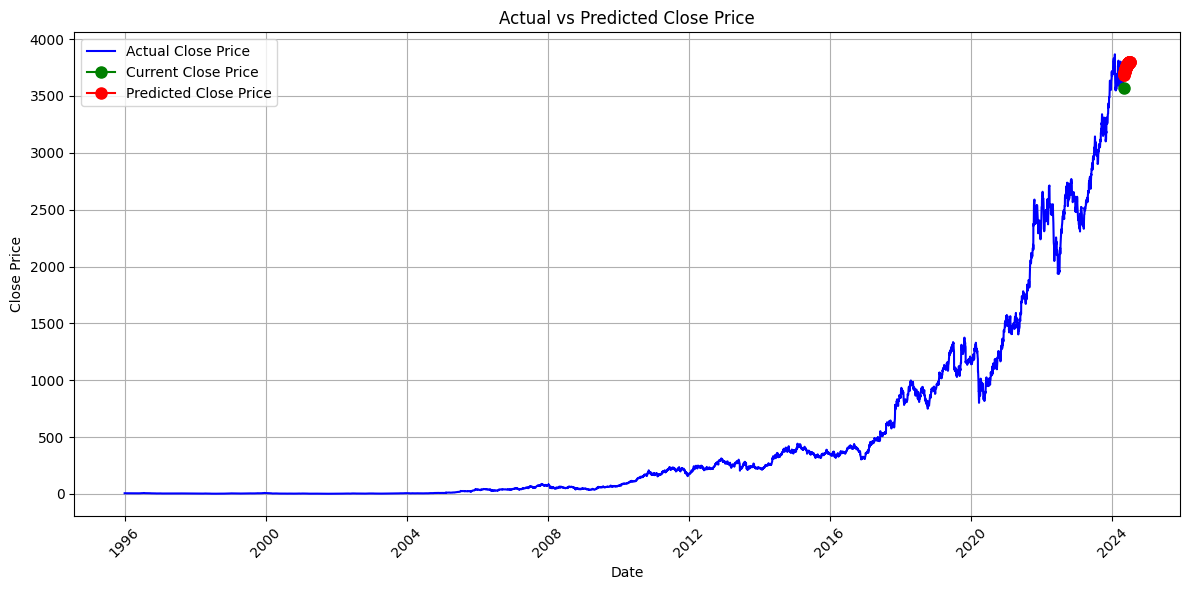

In [95]:
def predict_future_prices(model, data, look_back, num_days):
    last_sequence = data[-look_back:]  # Get the last sequence of known data
    predicted_prices = []
    for _ in range(num_days):
        prediction = model.predict(last_sequence.reshape(1, look_back, 1))  # Predict next day's price
        predicted_prices.append(prediction[0, 0])  # Append predicted price to list
        last_sequence = np.append(last_sequence[1:], prediction[0])  # Update last sequence with new prediction
    return scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))[:, 0]

# Predict future prices for the next 20 days
num_days = 60  # Change this value to predict a different number of days into the future
predicted_prices = predict_future_prices(model, scaled_data, look_back, num_days)

# Plot actual and predicted closing prices
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], scaler.inverse_transform(scaled_data), label='Actual Close Price', color='blue')
plt.plot(data['Date'].iloc[-1:], scaler.inverse_transform(scaled_data)[-1:], marker='o', markersize=8, color='green', label='Current Close Price')
plt.plot(pd.date_range(start=data['Date'].iloc[-1], periods=num_days+1, freq='D')[1:], predicted_prices, marker='o', markersize=8, color='red', label='Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [96]:
predicted_prices

array([3685.6816, 3687.199 , 3693.8928, 3701.164 , 3707.5593, 3712.5132,
       3716.3037, 3719.3079, 3721.8896, 3724.2942, 3726.6682, 3729.082 ,
       3731.5596, 3734.098 , 3736.6816, 3739.288 , 3741.8945, 3744.4783,
       3747.024 , 3749.5137, 3751.9385, 3754.2864, 3756.5525, 3758.7383,
       3760.8413, 3762.8625, 3764.8062, 3766.6753, 3768.4727, 3770.2034,
       3771.8674, 3773.4683, 3775.01  , 3776.4932, 3777.9202, 3779.2925,
       3780.6123, 3781.8828, 3783.105 , 3784.2817, 3785.4155, 3786.5068,
       3787.558 , 3788.5684, 3789.5415, 3790.4785, 3791.3813, 3792.2493,
       3793.0862, 3793.891 , 3794.6643, 3795.4097, 3796.1245, 3796.81  ,
       3797.4685, 3798.1023, 3798.712 , 3799.2969, 3799.8586, 3800.3987],
      dtype=float32)

In [97]:
model.save('TITAN.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [98]:
import joblib
joblib.dump(scaler, 'TITAN_minmax_scaler.pkl')

['TITAN_minmax_scaler.pkl']